In [1]:
import globin
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Imports for JupyterLite
try:
    import piplite
    await piplite.install(['ipywidgets'])
except ImportError:
    pass

import ipywidgets as widgets
from IPython.display import display

In [2]:
obs = globin.Observation("../../globin_inversion/hinode/hinode4d.20130912_102642.x50-80_y50-80.globin.fits")
#obs = globin.Observation("../../globin_inversion/tmp/obs_norm.fits")

In [34]:
# fpath = "../../globin_inversion/tmp/runs/m3_stray5p_inv"
#cycle = 2
# ref = globin.Atmosphere(f"{fpath}/../../muram_sunspot_QS_patch.fits")
# ref = globin.Atmosphere(f"{fpath}/../m3/inverted_atmos_c{cycle}.fits")
#ref = fits.open(f"{fpath}/inverted_atoms_c1.fits")
try:
    tmp = globin.atoms.AtomPars(f"{fpath}/inverted_atoms_c{cycle}.fits")
    print(tmp.data["loggf"][0,0])
except:
    pass

[-0.70900304 -1.18960357]


In [85]:
fpath = "../../globin_inversion/hinode/runs/m1_qsdc_patch_nosl"
cycle = 1
chi2 = fits.open(f"{fpath}/chi2_c{cycle}.fits")[0].data
inv = globin.Observation(f"{fpath}/inverted_spectra_c{cycle}.fits")
atm = globin.Atmosphere(f"{fpath}/inverted_atmos_c{cycle}.fits")
try:
    atoms = globin.atoms.AtomPars(f"{fpath}/inverted_atoms_c{cycle}.fits")
    print(atoms.data["loggf"][0,0])
except:
    pass

In [64]:
3p = [-0.70900304 -1.18960357]
0p = [-0.70128444 -1.18876454]
13p_inv = [-0.60108884 -1.07738601]

SyntaxError: invalid syntax (2274821501.py, line 1)

### Chi^2 plot

In [83]:
def get_final_chi2(chi2):
    nx, ny, nit = chi2.shape

    last_iter = np.zeros((nx,ny))
    best_chi2 = np.zeros((nx,ny))
    for idx in range(nx):
        for idy in range(ny):
            inds_non_zero = np.nonzero(chi2[idx,idy])[0]
            last_iter[idx,idy] = inds_non_zero[-1]
            best_chi2[idx,idy] = chi2[idx,idy,inds_non_zero[-1]]

    return best_chi2, last_iter

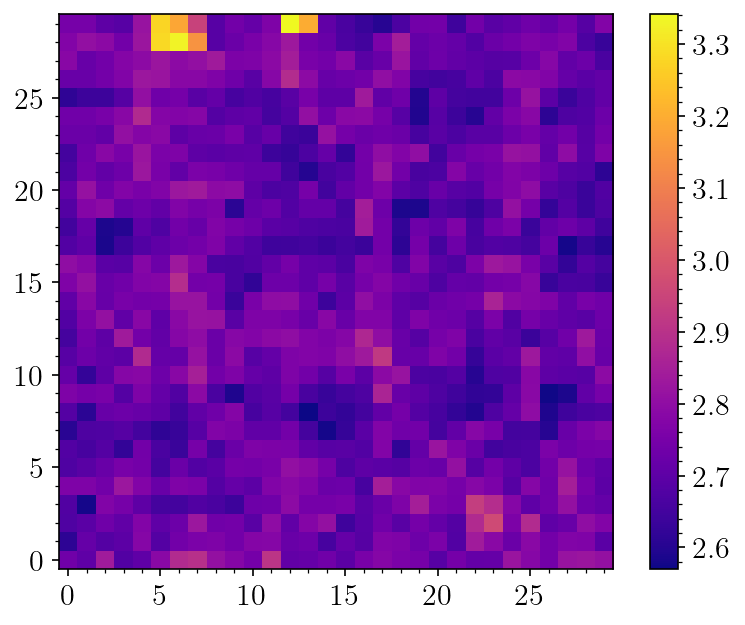

In [91]:
_chi2, last_iter = get_final_chi2(chi2)
_chi2 = np.log10(_chi2)

plt.imshow(_chi2.T, origin="lower")
plt.colorbar()

### Surface plots of different atmospheric parameters

In [51]:
def add_colorbar(fig, ax, im, label=None):
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axins = inset_axes(ax,
                       width="5%",
                       height="100%",
                       loc="lower left",
                       bbox_to_anchor=(1.02, 0., 1, 1),
                       bbox_transform=ax.transAxes,
                       borderpad=0)
    cbar = fig.colorbar(im, cax=axins)
    # cbar.ax.set_yticklabels(cbar.ax.get_yticks(), fontsize="medium")
    if label is not None:
        cbar.set_label(label)

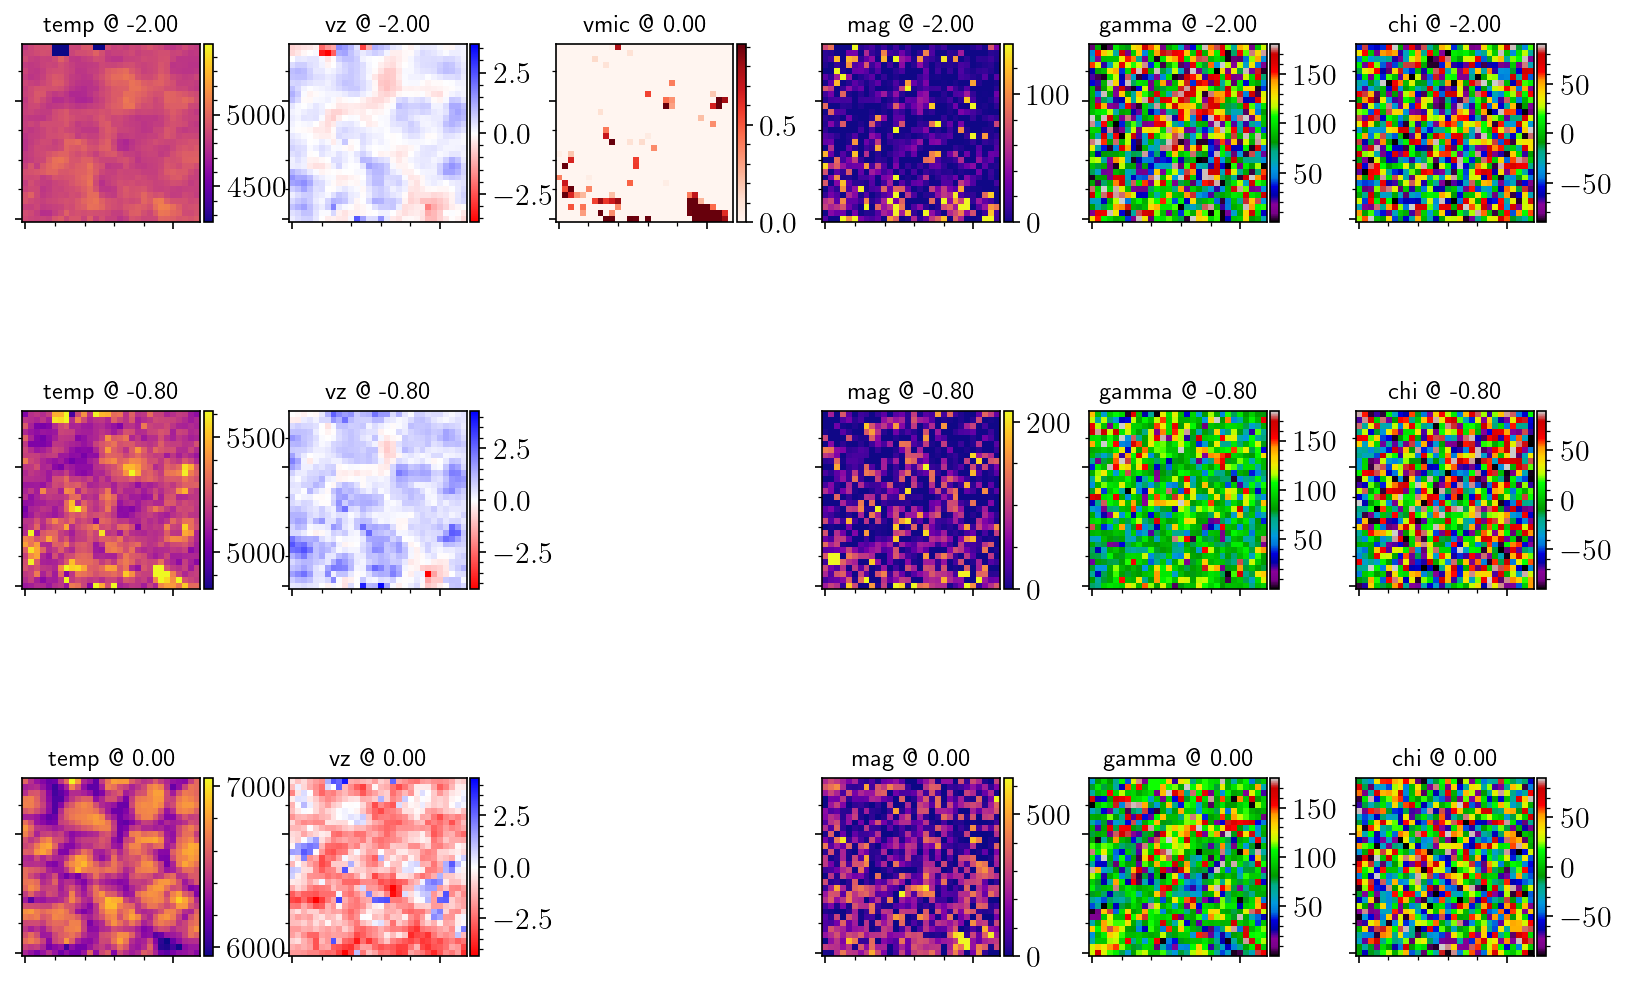

In [79]:
pars = ["temp", "vz", "vmic", "mag", "gamma", "chi"]
cmap = {"temp" : "plasma", "vz" : "bwr_r", "vmic" : "Reds", 
        "mag" : "plasma", "gamma" : "nipy_spectral", 
        "chi" : "nipy_spectral", "stray" : "plasma"}

# get the max number of nodes (in one of the parameters)
max_nodes = 0
for par in pars:
    if len(atm.nodes[par])>max_nodes:
        max_nodes = len(atm.nodes[par])

fig = plt.figure(figsize=(13,9))
gs = fig.add_gridspec(nrows=max_nodes, ncols=len(pars), wspace=0.5)

for idp, par in enumerate(pars):
    for idr in range(len(atm.nodes[par])):
        ax = fig.add_subplot(gs[idr,idp])
        vmax, vmin = None, None
        fact = 1
        if par=="gamma" or par=="chi":
            fact = 180/np.pi
        elif par=="vz":
            vlim = np.max(np.abs(atm.values[par][:,:,idr]))
            if vlim>8:
                vlim = 5
            vmax, vmin = vlim, -vlim
        else:
            mean = np.mean(atm.values[par][...,idr])
            std = np.std(atm.values[par][...,idr])
            vmin, vmax = mean - 3*std, mean + 3*std
            if par=="mag" and vmin<0:
                vmin = 0
            if par=="vmic" and vmin<0:
                vmin = 0
        ax.set_title("{:s} @ {:3.2f}".format(par, atm.nodes[par][idr]))
        im = ax.imshow(atm.values[par][:,:,idr].T*fact, origin="lower", cmap=cmap[par], vmax=vmax, vmin=vmin)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        add_colorbar(fig, ax, im)

### Comparison of observed and inverted Stokes spectra for different pixels

In [80]:
ref = None
def plot_spectra(idx, idy):
    globin.visualize.plot_spectra(obs.spec[idx,idy], obs.wavelength, inv=inv.spec[idx,idy])
def plot_atmosphere(idx, idy):
    globin.visualize.plot_atmosphere(atm, ["temp", "vz", "vmic", "mag", "gamma", "chi"], reference=ref, idx=idx, idy=idy)

In [81]:
w1 = widgets.IntSlider(value=0, min=0, max=obs.nx-1, description="idx", continuous_update=False)
w2 = widgets.IntSlider(value=0, min=0, max=obs.ny-1, description="idy", continuous_update=False)

out_s = widgets.interactive_output(plot_spectra, {'idx': w1, 'idy': w2})
out_a = widgets.interactive_output(plot_atmosphere, {'idx': w1, 'idy': w2})
widgets.VBox([widgets.VBox([w1, w2]), widgets.HBox([out_a, out_s])])